In [4]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
sys.path.append('../src')
from evaluation.visualizer import SentimentVisualizer

In [5]:
results_dir = Path('../results')
all_results = {}

for result_file in results_dir.rglob('results.pkl'):
    model_name = result_file.parent.name
    
    with open(result_file, 'rb') as f:
        results = pickle.load(f)
    
    all_results[model_name] = results

print(f"Loaded {len(all_results)} model results:")
for model_name in all_results.keys():
    print(f"  - {model_name}")


Loaded 3 model results:
  - stacking_20260206_142318
  - voting_20260206_141643
  - weighted_20260206_142013


In [6]:
comparison_data = []

for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results.get('precision_macro', 0),
        'Recall': results.get('recall_macro', 0),
        'F1-Score': results.get('f1_macro', 0)
    })

df = pd.DataFrame(comparison_data)
df = df.sort_values('F1-Score', ascending=False)

print("\nMODEL COMPARISON TABLE")
print("="*80)
print(df.to_string(index=False))


MODEL COMPARISON TABLE
                   Model  Accuracy  Precision   Recall  F1-Score
weighted_20260206_142013  0.712868   0.715964 0.715227  0.715573
  voting_20260206_141643  0.708707   0.711886 0.711045  0.711447
stacking_20260206_142318  0.691421   0.693002 0.694046  0.693472


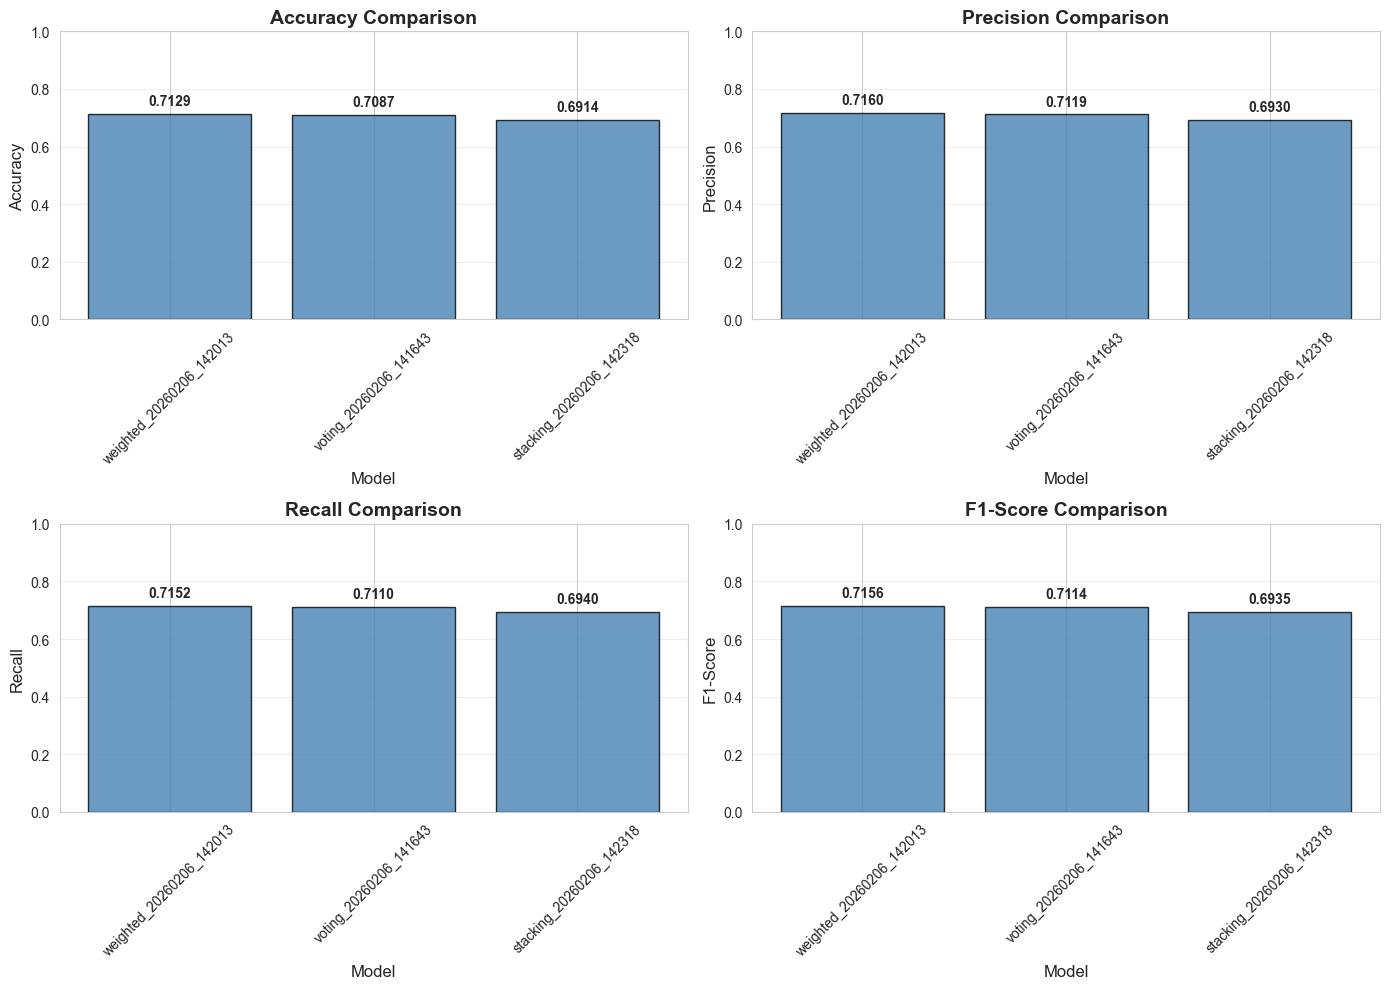

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(df['Model'], df[metric], color=['steelblue']*len(df), edgecolor='black', alpha=0.8)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars, df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


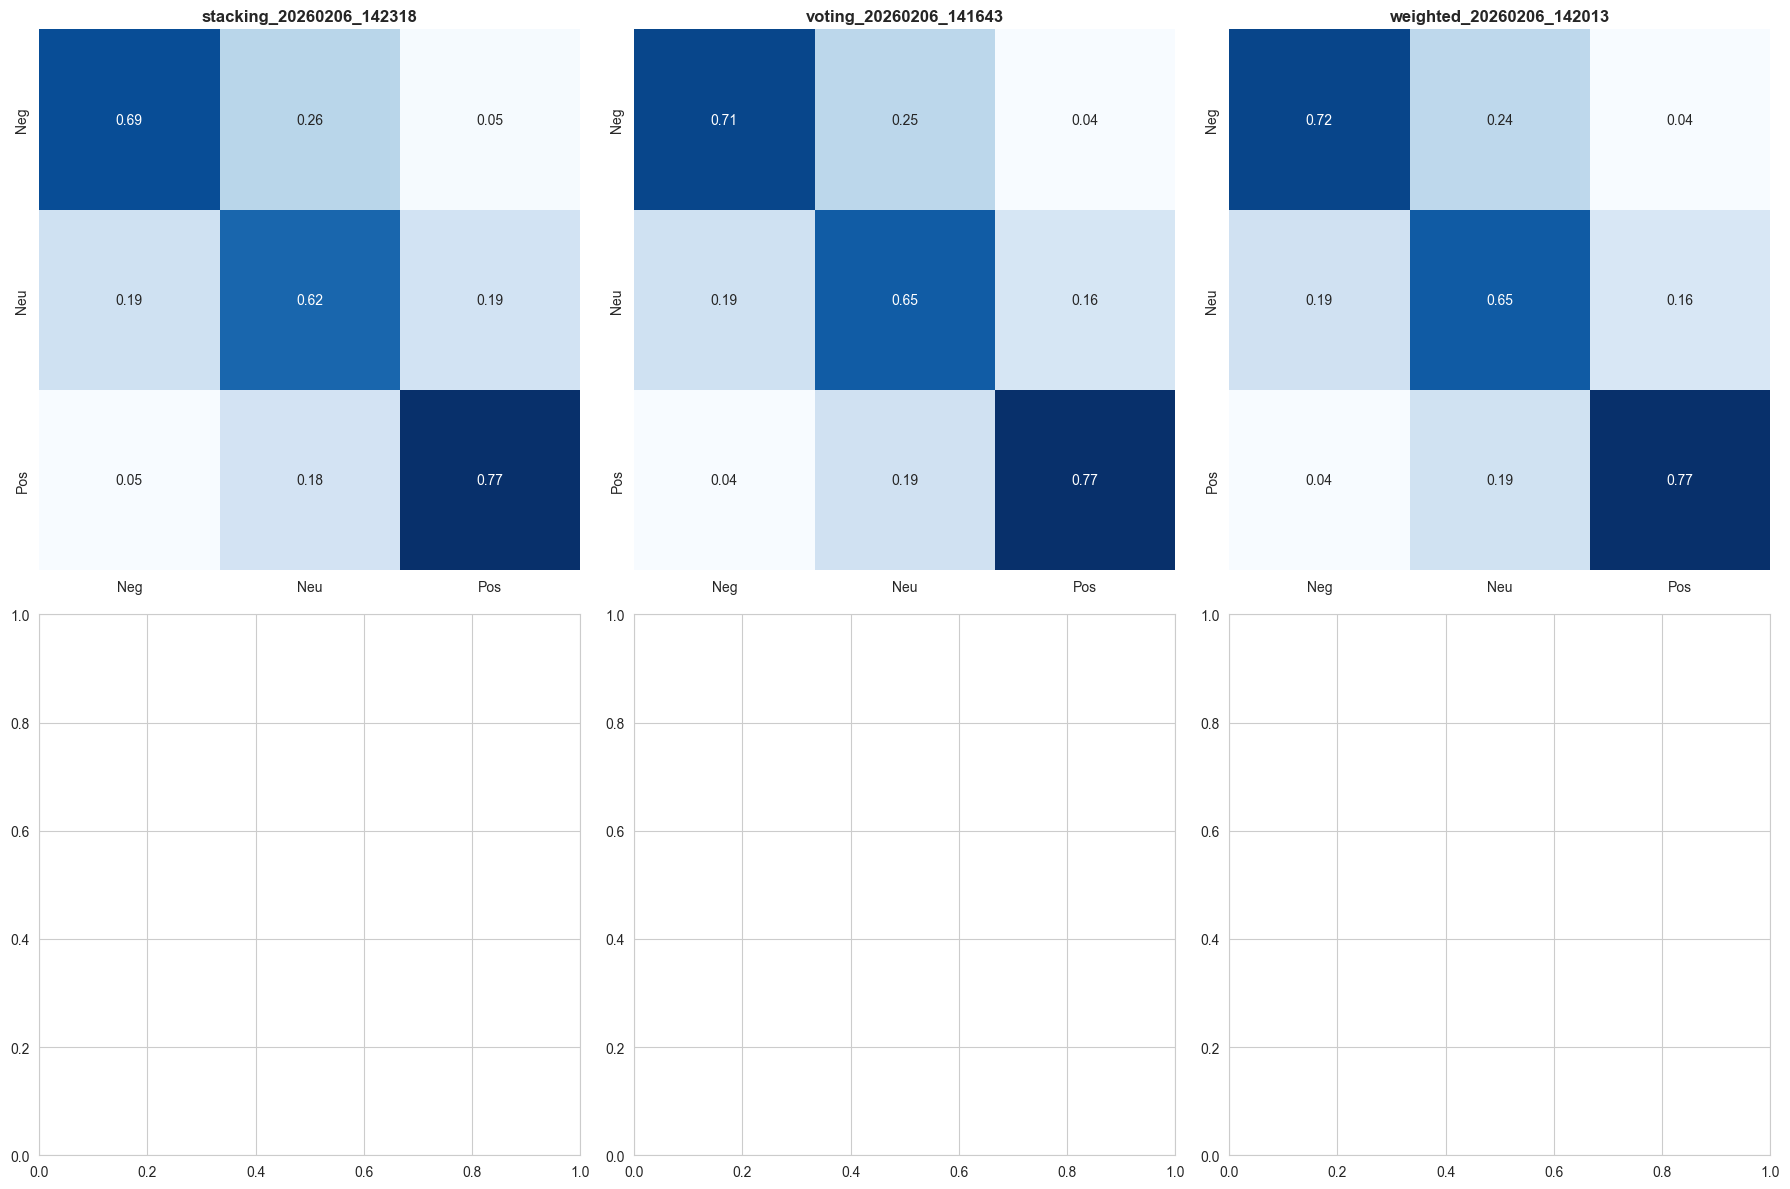

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

from sklearn.metrics import confusion_matrix

for idx, (model_name, results) in enumerate(list(all_results.items())[:6]):
    if idx >= 6:
        break
    
    cm = confusion_matrix(results['true_labels'], results['predictions'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'],
               ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
best_model_name = df.iloc[0]['Model']
worst_model_name = df.iloc[-1]['Model']

best_results = all_results[best_model_name]
worst_results = all_results[worst_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"  Accuracy: {best_results['accuracy']:.4f}")
print(f"  F1-Score: {best_results['f1_macro']:.4f}")

print(f"\nWORST MODEL: {worst_model_name}")
print(f"  Accuracy: {worst_results['accuracy']:.4f}")
print(f"  F1-Score: {worst_results['f1_macro']:.4f}")

print(f"\nIMPROVEMENT:")
print(f"  Accuracy: +{(best_results['accuracy'] - worst_results['accuracy'])*100:.2f}%")
print(f"  F1-Score: +{(best_results['f1_macro'] - worst_results['f1_macro'])*100:.2f}%")



BEST MODEL: weighted_20260206_142013
  Accuracy: 0.7129
  F1-Score: 0.7156

WORST MODEL: stacking_20260206_142318
  Accuracy: 0.6914
  F1-Score: 0.6935

IMPROVEMENT:
  Accuracy: +2.14%
  F1-Score: +2.21%


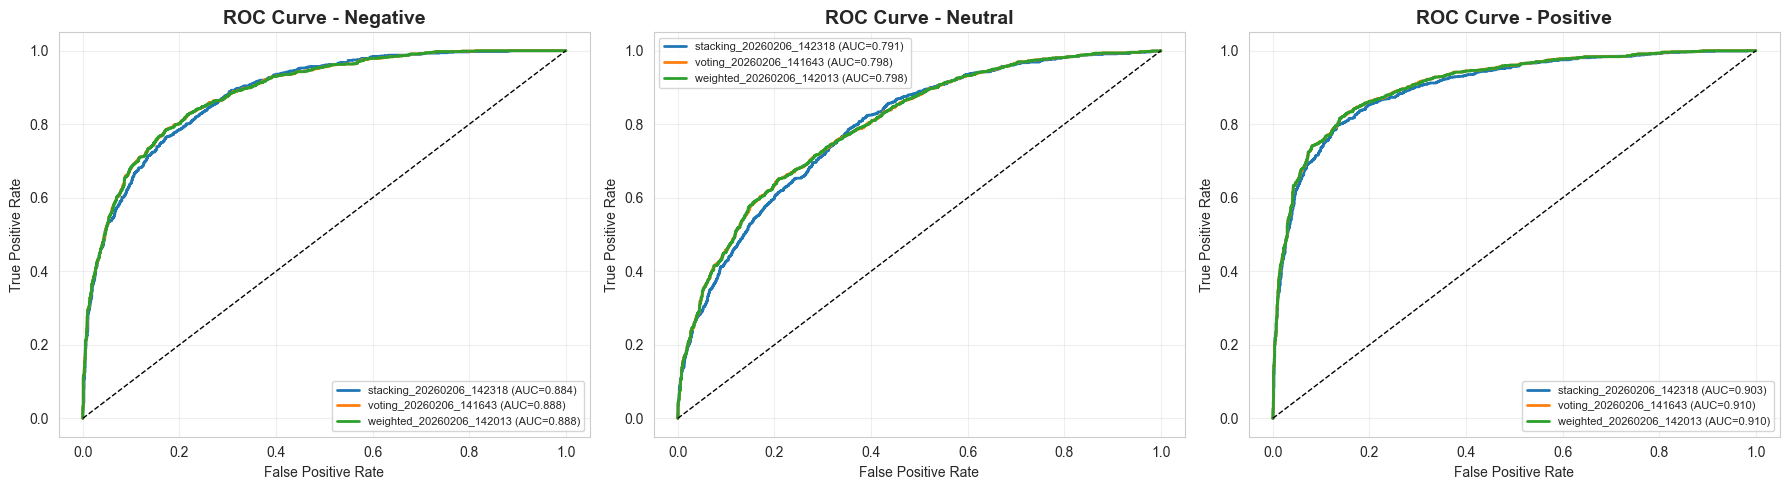

In [10]:
from sklearn.metrics import roc_curve, auc
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = ['Negative', 'Neutral', 'Positive']

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    
    for model_name, results in all_results.items():
        y_true_binary = (results['true_labels'] == class_idx).astype(int)
        y_scores = results['probabilities'][:, class_idx]
        
        fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {class_name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
summary = df.describe()
print("\nSTATISTICAL SUMMARY")
print("="*80)
print(summary)

print(f"\nBest Overall Accuracy: {df['Accuracy'].max():.4f} ({df.loc[df['Accuracy'].idxmax(), 'Model']})")
print(f"Best Overall F1-Score: {df['F1-Score'].max():.4f} ({df.loc[df['F1-Score'].idxmax(), 'Model']})")
print(f"Average Accuracy: {df['Accuracy'].mean():.4f}")
print(f"Average F1-Score: {df['F1-Score'].mean():.4f}")


STATISTICAL SUMMARY
       Accuracy  Precision    Recall  F1-Score
count  3.000000   3.000000  3.000000  3.000000
mean   0.704332   0.706951  0.706773  0.706831
std    0.011373   0.012251  0.011218  0.011751
min    0.691421   0.693002  0.694046  0.693472
25%    0.700064   0.702444  0.702546  0.702460
50%    0.708707   0.711886  0.711045  0.711447
75%    0.710787   0.713925  0.713136  0.713510
max    0.712868   0.715964  0.715227  0.715573

Best Overall Accuracy: 0.7129 (weighted_20260206_142013)
Best Overall F1-Score: 0.7156 (weighted_20260206_142013)
Average Accuracy: 0.7043
Average F1-Score: 0.7068
